<a href="https://colab.research.google.com/github/Ekram49/DS-Unit-2-Kaggle-Challenge/blob/master/Ekram_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Train/Test/Validate split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train, val = train_test_split(train, train_size = .8, test_size = .2,
stratify = train['status_group'], random_state = 42)

In [6]:
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

# Data cleaning

In [0]:
import numpy as np

def wrangle(clean):
  clean = clean.copy()
  clean['latitude'] = clean['latitude'].replace(-2e-08, 0)
  zeros = ['longitude', 'latitude', 'construction_year', 'gps_height', 'population']
  for col in zeros:
    clean[col] = clean[col].replace(0, np.nan)
    clean[col+'_MISSING'] = clean[col].isnull()

    clean = clean.drop(columns = ['quantity_group', 'payment_type', 'recorded_by', 'id'])
    clean['date_recorded'] = pd.to_datetime(clean['date_recorded'], infer_datetime_format=True)

    clean['year_recorded'] = clean['date_recorded'].dt.year
    clean['month_recorded'] = clean['date_recorded'].dt.month
    clean['day_recorded'] = clean['date_recorded'].dt.day
    clean = clean.drop(columns='date_recorded')

    clean['years'] = clean['year_recorded'] - clean['construction_year']
    clean['years_Missing'] = clean['years'].isnull()

    return clean

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Baseline for classification

In [8]:
train['status_group'].value_counts(normalize = True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

# Feature selection

In [0]:
target = 'status_group'

train_features = train.drop(columns = [target])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude = 'number').nunique()


categorical_features = cardinality[cardinality <=50].index.tolist()

features = numeric_features + categorical_features

In [0]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

# Pipeline

In [0]:
import category_encoders as ce
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

In [39]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    RandomForestClassifier(random_state = 0, n_jobs = -1)
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
print(accuracy_score(y_val, y_pred))

0.8085858585858586


# Confusion matrix

In [19]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [0]:
from sklearn.metrics import plot_confusion_matrix

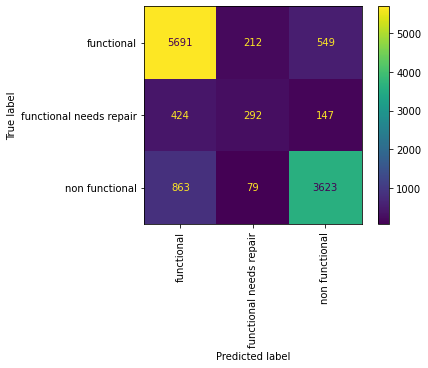

In [42]:
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')